In [46]:
import os
import math
import json
import numpy as np
import pandas as pd
from pathlib import Path
from statistics import harmonic_mean, mean
from scipy.stats.mstats import gmean

DATA_DIRECTORY = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')
pd.set_option('display.max_rows', 500)

def remove_parens_content(string):
    try:
        result = re.sub(PARENS_CONTENT_REGEX, "", string)
        return result
    except:
        return string

## Prerequisite

You need to run the `cmu_phonemes_graphemes.ipynb` first. Its output files feed into this notebook.

## Loading Data

In [2]:
cmudict_7b_english = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'cmu_7b_graphemes_phonemes.csv'),
    encoding = "ISO-8859-1",
    keep_default_na=False
)

## Functions: Phoneme-To-Grapheme & Grapheme-To-Phoneme Probabilities

In [3]:
# Get phoneme <-> grapheme count & probability matrices
def get_phoneme_grapheme_count_df(phonemes_to_graphemes, graphemes_to_phonemes):
    column_names = sorted(graphemes_to_phonemes.keys())
    row_names = sorted(phonemes_to_graphemes.keys())
    phoneme_grapheme_count_df = pd.DataFrame(index=row_names, columns=column_names).fillna(0)
    
    for phoneme, graphemes in phonemes_to_graphemes.items():
        for grapheme, grapheme_metadata in graphemes.items():
            phoneme_grapheme_count_df.loc[phoneme, grapheme] = grapheme_metadata['count']
    return phoneme_grapheme_count_df.fillna(0)


def get_phoneme_grapheme_probability_df(phonemes_to_graphemes, graphemes_to_phonemes, phoneme_grapheme_count_df):
    column_names = sorted(graphemes_to_phonemes.keys())
    row_names = sorted(phonemes_to_graphemes.keys())
    phoneme_grapheme_probability_df = pd.DataFrame(index=row_names, columns=column_names).fillna(0)

    # probability that the phoneme 'AA' is represented by the grapheme 'A'
    for i, row in phoneme_grapheme_count_df.iterrows():
        phoneme = row.name
        total_phonemes = row.sum()
        for grapheme in phoneme_grapheme_count_df.columns:
            count_grapheme = phoneme_grapheme_count_df.loc[phoneme, grapheme]
            probability_grapheme = float(count_grapheme) / float(total_phonemes)
            phoneme_grapheme_probability_df.loc[phoneme, grapheme] = probability_grapheme
            
    return phoneme_grapheme_probability_df.fillna(0)
        
def get_grapheme_phoneme_probability_df(phonemes_to_graphemes, graphemes_to_phonemes, phoneme_grapheme_count_df):
    column_names = sorted(graphemes_to_phonemes.keys())
    row_names = sorted(phonemes_to_graphemes.keys())
    grapheme_phoneme_probability_df = pd.DataFrame(index=row_names, columns=column_names).fillna(0)

    # probability that the grapheme 'A' corresponds to the phoneme 'AA'
    for column_name in phoneme_grapheme_count_df:
        column = phoneme_grapheme_count_df[column_name]
        grapheme = column.name
        total_graphemes = column.sum()

        for phoneme in phoneme_grapheme_count_df.index:
            count_phoneme = phoneme_grapheme_count_df.loc[phoneme, grapheme]
            probability_phoneme = float(count_phoneme) / float(total_graphemes)
            grapheme_phoneme_probability_df.loc[phoneme, grapheme] = probability_phoneme
    return grapheme_phoneme_probability_df.fillna(0)

## Functions: Complexity/Regularity Metrics

In [18]:
def get_all_spellings_from_phonemes(phonemes, phoneme_grapheme_correspondence):
    all_graphemes = []
    for phoneme in phonemes.split(' '):
        graphemes = phoneme_grapheme_correspondence[phoneme].keys()
        all_graphemes.append(graphemes)
    
    all_spellings = list(product(*all_graphemes))
    return all_spellings 

def get_spelling_probability_given_phonemes(phonemes, graphemes, phoneme_grapheme_probability):
    probability = 1
    graphemes = graphemes.split(' ')
    phonemes = phonemes.split(' ')
    for item in zip(graphemes, phonemes):
        grapheme = item[0]
        phoneme = item[1]

        probability *= phoneme_grapheme_probability.loc[phoneme, grapheme]
    return probability

def get_phoneme_to_grapheme_max_probabilities(phoneme_grapheme_probability):
    phoneme_maxes = {}
    for phoneme in phoneme_grapheme_probability.index:
        phoneme_maxes[phoneme] = max(phoneme_grapheme_probability.loc[phoneme])
    return phoneme_maxes

def get_spelling_likelihood_metric_given_phonemes(phonemes, graphemes, phoneme_grapheme_probability, phoneme_maxes):
    likelihoods = []
    graphemes = graphemes.split(' ')
    phonemes = phonemes.split(' ')
    
    for item in zip(graphemes, phonemes):
        grapheme = item[0]
        phoneme = item[1]
        phoneme_max = phoneme_maxes[phoneme]
        likelihoods.append(phoneme_grapheme_probability.loc[phoneme, grapheme] / phoneme_max)
                                                           
    likelihood_metric = harmonic_mean(likelihoods)
                                                           
    return likelihood_metric

def get_pronunciation_probability_given_graphemes(graphemes, phonemes, grapheme_phoneme_probability):
    probability = 1
    graphemes = graphemes.split(' ')
    phonemes = phonemes.split(' ')
    for item in zip(graphemes, phonemes):
        grapheme = item[0]
        phoneme = item[1]
        
        probability *= grapheme_phoneme_probability.loc[phoneme, grapheme]
    return probability

def get_grapheme_to_phoneme_max_probabilities(grapheme_phoneme_probability):
    grapheme_maxes = {}
    for grapheme in grapheme_phoneme_probability.columns:
        grapheme_maxes[grapheme] = max(grapheme_phoneme_probability.loc[:,grapheme])
    return grapheme_maxes

def get_pronunciation_likelihood_metric_given_graphemes(graphemes, phonemes, grapheme_phoneme_probability, grapheme_maxes):
    likelihoods = []
    graphemes = graphemes.split(' ')
    phonemes = phonemes.split(' ')
        
    for item in zip(graphemes, phonemes):
        grapheme = item[0]
        phoneme = item[1]
        grapheme_max = grapheme_maxes[grapheme]
        likelihoods.append(grapheme_phoneme_probability.loc[phoneme, grapheme] / grapheme_max)
                                                           
    likelihood_metric = harmonic_mean(likelihoods)
                                                           
    return likelihood_metric

## Functions: Information Entropy

In [5]:
def get_entropic_measure(probabilities):
    return abs(-1 * sum([p * math.log(p, 2) for p in probabilities]))

def get_grapheme_entropy(graphemes_to_phonemes, grapheme_phoneme_probability_df):
    grapheme_entropy = {}
    for grapheme in graphemes_to_phonemes:
        probabilities = [grapheme_phoneme_probability_df[grapheme][phoneme] for phoneme in graphemes_to_phonemes[grapheme]]
        entropy = get_entropic_measure(probabilities)
        grapheme_entropy[grapheme] = entropy
    return grapheme_entropy

def get_phoneme_entropy(phonemes_to_graphemes, phoneme_grapheme_probability_df):
    phoneme_entropy = {}
    for phoneme in phonemes_to_graphemes:
        probabilities = [phoneme_grapheme_probability_df[grapheme][phoneme] for grapheme in phonemes_to_graphemes[phoneme]]
        entropy = get_entropic_measure(probabilities)
        phoneme_entropy[phoneme] = entropy
    return phoneme_entropy

def get_phoneme_consonant_entropy(phoneme_entropy):
    vowel_phonemes = ['AH', 'EY', 'AA', 'AE', 'OW', 'IH', 'EH', 'AO', 'AY', 'UW', 'UH', 'AW', 'OY']
    phoneme_consonant_entropy = {k: v for k,v in phoneme_entropy.items() if k not in vowel_phonemes}
    return phoneme_consonant_entropy

def get_grapheme_consonant_entropy(phoneme_entropy):
    vowel_graphemes = []
    for grapheme in grapheme_entropy:
        only_vowel = True
        for char in grapheme:
            if char not in ['A', 'E', 'I', 'O', 'U']:
                only_vowel = False
        if only_vowel:
            vowel_graphemes.append(grapheme)
            
    grapheme_consonant_entropy = {k: v for k,v in grapheme_entropy.items() if k not in vowel_graphemes}
    
    return grapheme_consonant_entropy

def get_pronunciation_entropy(graphemes, grapheme_entropy):
    graphemes = graphemes.split(' ')
    entropies = [grapheme_entropy[g] if g in grapheme_entropy else 0 for g in graphemes]
    zeros = [i for i in entropies if i == 0]
    entropies = [i for i in entropies if i != 0]
    
    l = zeros + [gmean(entropies)] * len(entropies)
    return mean(l) * math.sqrt(len(graphemes))

def get_spelling_entropy(phonemes, phoneme_entropy):
    phonemes = phonemes.split(' ')
    entropies = [phoneme_entropy[p] if p in phoneme_entropy else 0 for p in phonemes]
    zeros = [i for i in entropies if i == 0]
    entropies = [i for i in entropies if i != 0]
    
    l = zeros + [gmean(entropies)] * len(entropies)
    return mean(l)

def get_entropy_metric(phonemes, graphemes, grapheme_entropy, phoneme_entropy):
    p_entropy = get_pronunciation_entropy(graphemes, grapheme_entropy)
    s_entropy = get_spelling_entropy(phonemes, phoneme_entropy)
    return harmonic_mean([p_entropy, s_entropy])



## Adding Metrics for Graphemes / Phonemes

In [6]:
with open(os.path.join(DATA_DIRECTORY, 'cmu_7b_graphemes_to_phonemes.json')) as f:
    graphemes_to_phonemes = json.load(f)
    
with open(os.path.join(DATA_DIRECTORY, 'cmu_7b_phonemes_to_graphemes.json')) as f:
    phonemes_to_graphemes = json.load(f)

In [7]:
phoneme_grapheme_count_df = get_phoneme_grapheme_count_df(phonemes_to_graphemes, graphemes_to_phonemes)
phoneme_grapheme_probability_df = get_phoneme_grapheme_probability_df(
    phonemes_to_graphemes,
    graphemes_to_phonemes,
    phoneme_grapheme_count_df
)
grapheme_phoneme_probability_df = get_grapheme_phoneme_probability_df(
    phonemes_to_graphemes,
    graphemes_to_phonemes,
    phoneme_grapheme_count_df
)      

In [8]:
phoneme_entropy = get_phoneme_entropy(phonemes_to_graphemes, phoneme_grapheme_probability_df)
phoneme_consonant_entropy = get_phoneme_consonant_entropy(phoneme_entropy)

grapheme_entropy = get_grapheme_entropy(graphemes_to_phonemes, grapheme_phoneme_probability_df)
grapheme_consonant_entropy = get_grapheme_consonant_entropy(grapheme_entropy)

In [19]:
phoneme_maxes = get_phoneme_to_grapheme_max_probabilities(phoneme_grapheme_probability_df)
grapheme_maxes = get_grapheme_to_phoneme_max_probabilities(grapheme_phoneme_probability_df)

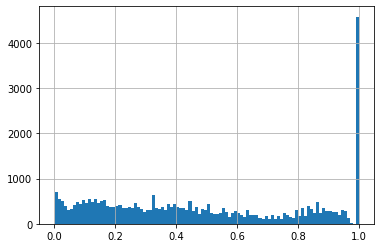

In [21]:
cmudict_7b_english['spelling_likelihood'] = cmudict_7b_english.apply(
    lambda x: get_spelling_likelihood_metric_given_phonemes(
        x.final_phonemes,
        x.final_graphemes,
        phoneme_grapheme_probability_df,
        phoneme_maxes
    ), axis=1)

hist = cmudict_7b_english['spelling_likelihood'].hist(bins=100)

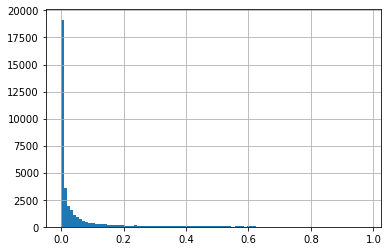

In [22]:
cmudict_7b_english['spelling_probability'] = cmudict_7b_english.apply(
    lambda x: get_spelling_probability_given_phonemes(
        x.final_phonemes,
        x.final_graphemes,
        phoneme_grapheme_probability_df
    ), axis=1)

hist = cmudict_7b_english['spelling_probability'].hist(bins=100)

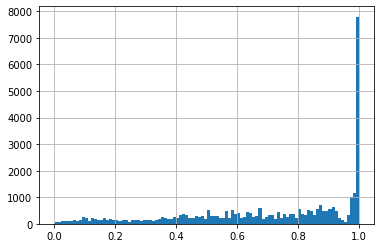

In [23]:
cmudict_7b_english['pronunciation_likelihood'] = cmudict_7b_english.apply(
    lambda x: get_pronunciation_likelihood_metric_given_graphemes(
        x.final_graphemes,
        x.final_phonemes,
        grapheme_phoneme_probability_df,
        grapheme_maxes
    ), axis=1)

hist = cmudict_7b_english['pronunciation_likelihood'].hist(bins=100)

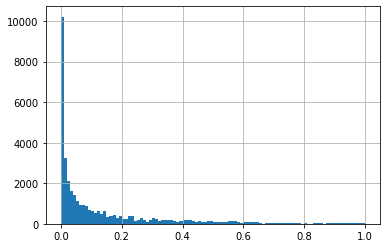

In [24]:
cmudict_7b_english['pronunciation_probability'] = cmudict_7b_english.apply(
    lambda x: get_pronunciation_probability_given_graphemes(
        x.final_graphemes,
        x.final_phonemes,
        grapheme_phoneme_probability_df
    ), axis=1)

hist = cmudict_7b_english['pronunciation_probability'].hist(bins=100)

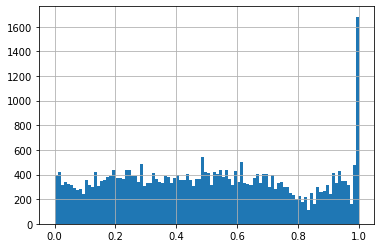

In [26]:
cmudict_7b_english['harmonic_spelling_pronunciation_likelihood'] = cmudict_7b_english.apply(
    lambda x: harmonic_mean([
        x.spelling_likelihood,
        x.pronunciation_likelihood
    ]), axis=1)

hist = cmudict_7b_english['harmonic_spelling_pronunciation_likelihood'].hist(bins=100)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:339: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/statistics.py:355: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))


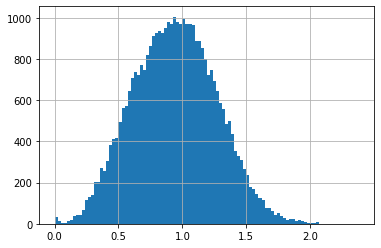

In [29]:
cmudict_7b_english['entropy_metric'] = cmudict_7b_english.apply(
    lambda x: get_entropy_metric(
        x.final_phonemes,
        x.final_graphemes,
        grapheme_entropy,
        phoneme_entropy
    ), axis=1)

hist = cmudict_7b_english['entropy_metric'].hist(bins=100)

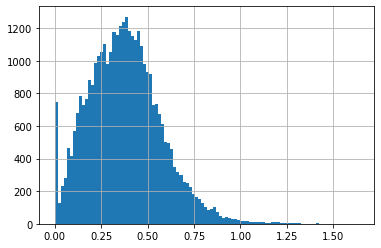

In [30]:
cmudict_7b_english['entropy_metric_consonant'] = cmudict_7b_english.apply(
    lambda x: get_entropy_metric(
        x.final_phonemes,
        x.final_graphemes,
        grapheme_consonant_entropy,
        phoneme_consonant_entropy
    ), axis=1)

hist = cmudict_7b_english['entropy_metric_consonant'].hist(bins=100)

## Adding Metrics for Silent Graphemes / Phonemes

In [31]:
with open(os.path.join(DATA_DIRECTORY, 'cmu_7b_silent_graphemes_to_phonemes.json')) as f:
    silent_graphemes_to_phonemes = json.load(f)
    
with open(os.path.join(DATA_DIRECTORY, 'cmu_7b_silent_phonemes_to_graphemes.json')) as f:
    silent_phonemes_to_graphemes = json.load(f)

In [32]:
silent_phoneme_grapheme_count_df = get_phoneme_grapheme_count_df(silent_phonemes_to_graphemes, silent_graphemes_to_phonemes)
silent_phoneme_grapheme_probability_df = get_phoneme_grapheme_probability_df(
    silent_phonemes_to_graphemes,
    silent_graphemes_to_phonemes,
    silent_phoneme_grapheme_count_df
)
silent_grapheme_phoneme_probability_df = get_grapheme_phoneme_probability_df(
    silent_phonemes_to_graphemes,
    silent_graphemes_to_phonemes,
    silent_phoneme_grapheme_count_df
)      

In [33]:
silent_grapheme_entropy = get_grapheme_entropy(silent_graphemes_to_phonemes, silent_grapheme_phoneme_probability_df)
silent_grapheme_consonant_entropy = get_grapheme_consonant_entropy(silent_grapheme_entropy)

silent_phoneme_entropy = get_phoneme_entropy(silent_phonemes_to_graphemes, silent_phoneme_grapheme_probability_df)
silent_phoneme_consonant_entropy = get_phoneme_consonant_entropy(silent_phoneme_entropy)

In [34]:
silent_phoneme_maxes = get_phoneme_to_grapheme_max_probabilities(silent_phoneme_grapheme_probability_df)
silent_grapheme_maxes = get_grapheme_to_phoneme_max_probabilities(silent_grapheme_phoneme_probability_df)

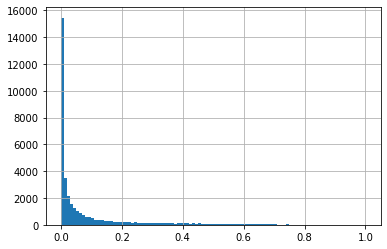

In [35]:
cmudict_7b_english['silent_spelling_probability'] = cmudict_7b_english.apply(
    lambda x: get_spelling_probability_given_phonemes(
        x.silent_phonemes,
        x.silent_graphemes,
        silent_phoneme_grapheme_probability_df
    ), axis=1)

hist = cmudict_7b_english['silent_spelling_probability'].hist(bins=100)

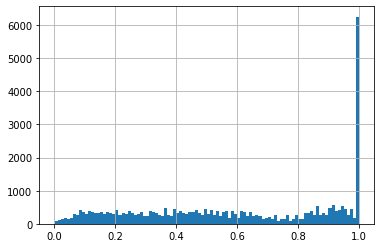

In [36]:
cmudict_7b_english['silent_spelling_likelihood'] = cmudict_7b_english.apply(
    lambda x: get_spelling_likelihood_metric_given_phonemes(
        x.silent_phonemes,
        x.silent_graphemes,
        silent_phoneme_grapheme_probability_df,
        silent_phoneme_maxes
    ), axis=1)

hist = cmudict_7b_english['silent_spelling_likelihood'].hist(bins=100)

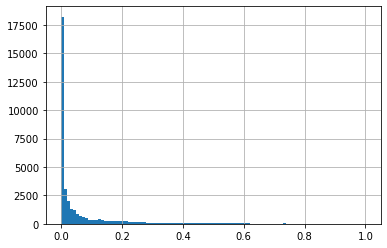

In [37]:
cmudict_7b_english['silent_pronunciation_probability'] = cmudict_7b_english.apply(
    lambda x: get_pronunciation_probability_given_graphemes(
        x.silent_graphemes,
        x.silent_phonemes,
        silent_grapheme_phoneme_probability_df
    ), axis=1)

hist = cmudict_7b_english['silent_pronunciation_probability'].hist(bins=100)

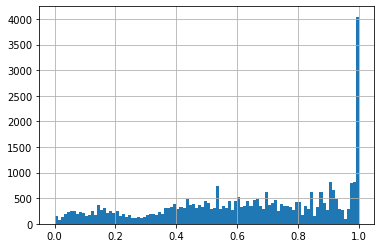

In [38]:
cmudict_7b_english['silent_pronunciation_likelihood'] = cmudict_7b_english.apply(
    lambda x: get_pronunciation_likelihood_metric_given_graphemes(
        x.silent_graphemes,
        x.silent_phonemes,
        silent_grapheme_phoneme_probability_df,
        silent_grapheme_maxes
    ), axis=1)

hist = cmudict_7b_english['silent_pronunciation_likelihood'].hist(bins=100)

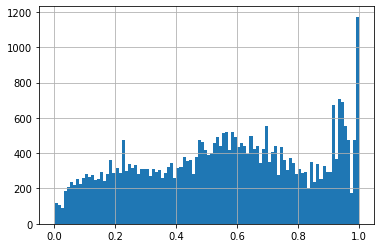

In [40]:
cmudict_7b_english['silent_harmonic_spelling_pronunciation_likelihood'] = cmudict_7b_english.apply(
    lambda x: harmonic_mean([
        x.silent_spelling_likelihood,
        x.silent_pronunciation_likelihood
    ]), axis=1)

hist = cmudict_7b_english['silent_harmonic_spelling_pronunciation_likelihood'].hist(bins=100)

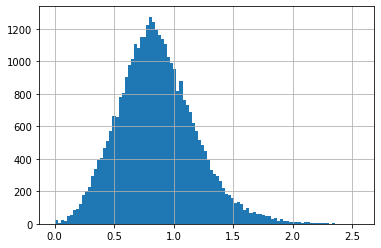

In [41]:
cmudict_7b_english['silent_entropy_metric'] = cmudict_7b_english.apply(
    lambda x: get_entropy_metric(
        x.silent_phonemes,
        x.silent_graphemes,
        silent_grapheme_entropy,
        silent_phoneme_entropy
    ), axis=1)

hist = cmudict_7b_english['silent_entropy_metric'].hist(bins=100)

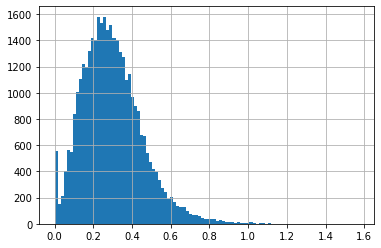

In [42]:
cmudict_7b_english['silent_entropy_metric_consonant'] = cmudict_7b_english.apply(
    lambda x: get_entropy_metric(
        x.silent_phonemes,
        x.silent_graphemes,
        silent_grapheme_consonant_entropy,
        silent_phoneme_consonant_entropy
    ), axis=1)

hist = cmudict_7b_english['silent_entropy_metric_consonant'].hist(bins=100)

## Adding Word Frequency

The above metrics had too many wildcards and couldn't fully encapsulate what makes spelling or pronouncing a word difficult for readers. The frequency of a word in a large corpus can address this missing component and produce a more intuitive list of complex vs. simple words.

**Source:** [Natural Language Corpus Data](https://norvig.com/ngrams/)

**Description:** The file is derived from the [Google Web Trillion Word Corpus](https://ai.googleblog.com/2006/08/all-our-n-gram-are-belong-to-you.html)

In [43]:
word_frequency = pd.read_csv(
    os.path.join(DATA_DIRECTORY, 'count_1w.txt'),
    encoding = "ISO-8859-1",
    header=None,
    names=['word', 'count'],
    keep_default_na=False,
    sep='\t'
)

In [44]:
word_frequency['frequency'] = word_frequency['count'] / sum(word_frequency['count'])
word_frequency['log'] = [math.log(c) for c in word_frequency['count']]
word_frequency['normalized_log'] = word_frequency['log'] / max(word_frequency['log'])

In [82]:
cmudict_7b_english['formatted_word'] = [remove_parens_content(w).lower() for w in cmudict_7b_english['word']]
word_normalized_log = dict(zip(word_frequency['word'], word_frequency['normalized_log']))
cmudict_7b_english['word_freq_normalized'] = [word_normalized_log[w] if w in word_normalized_log else .45 for w in cmudict_7b_english['formatted_word']]

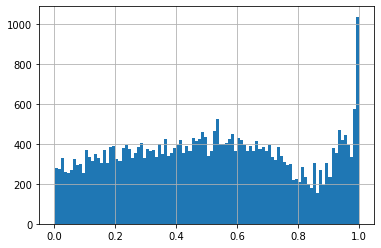

In [83]:
cmudict_7b_english['combined_harmonic_spelling_pronunciation_likelihood'] = cmudict_7b_english.apply(
    lambda x: harmonic_mean([
        x.spelling_likelihood,
        x.pronunciation_likelihood,
        x.silent_spelling_likelihood,
        x.silent_pronunciation_likelihood
    ]), axis=1)

hist = cmudict_7b_english['combined_harmonic_spelling_pronunciation_likelihood'].hist(bins=100)

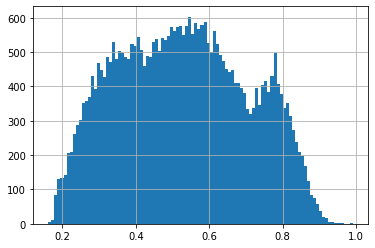

In [102]:
cmudict_7b_english['combined_likelihood_normalized_by_frequency'] = (
    3 * cmudict_7b_english['combined_harmonic_spelling_pronunciation_likelihood'] +
    2 * cmudict_7b_english['word_freq_normalized']
) / 5

hist = cmudict_7b_english['combined_likelihood_normalized_by_frequency'].hist(bins=100)

In [103]:
cmudict_7b_english_simplified = cmudict_7b_english[
    ~(cmudict_7b_english['word'].str.contains('\(')) & 
    ~(cmudict_7b_english['word'].str.contains('-')) # & 
#     ~(cmudict_7b_english['word_freq_normalized'] == .39)
]
cmudict_7b_english_simplified

,word,phonemes,in_english,num_initial_spellings,initial_graphemes,initial_phonemes,phonetisaurus_graphemes,phonetisaurus_phonemes,m2m_graphemes,m2m_phonemes,...,silent_spelling_likelihood,silent_pronunciation_probability,silent_pronunciation_likelihood,silent_harmonic_spelling_pronunciation_likelihood,silent_entropy_metric,silent_entropy_metric_consonant,formatted_word,word_freq_normalized,combined_harmonic_spelling_pronunciation_likelihood,combined_likelihood_normalized_by_frequency
0,A,AH0,True,1,A,AH,A,EY,A,AH,...,1.000000,0.315769,1.000000,1.000000,2.370540,0.000000,a,0.960813,1.000000,0.984325
2,AA,EY2 EY1,True,1,A A,EY EY,,,A A,EY EY,...,1.000000,0.025896,0.509621,0.675164,1.913827,0.000000,aa,0.722156,0.676159,0.694558
3,AARDVARK,AA1 R D V AA2 R K,True,1,AA R D V A R K,AA R D V AA R K,A A R D V A R K,AA _ R D V AA R K,AA R D V A R K,AA R D V AA R K,...,0.435985,0.000419,0.478652,0.456323,0.627284,0.145473,aardvark,0.559508,0.100381,0.284031
4,ABACK,AH0 B AE1 K,True,1,A B A CK,AH B AE K,A B A CK,AH B AE K,A B A CK,AH B AE K,...,0.311925,0.087955,0.970950,0.472164,0.414233,0.000000,aback,0.524497,0.480963,0.498377
5,ABACUS,AE1 B AH0 K AH0 S,True,1,A B A C U S,AE B AH K AH S,A B A C U S,AE B AH K AH S,A B A C U S,AE B AH K AH S,...,0.915797,0.029298,0.980444,0.947019,0.773234,0.402296,abacus,0.579620,0.939094,0.795304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35731,ZORRO,Z AO1 R OW2,True,1,Z O RR O,Z AO R OW,Z O R R O,Z AO R _ OW,Z O RR O,Z AO R OW,...,0.100215,0.031354,0.689527,0.174997,0.924034,0.214100,zorro,0.578671,0.175533,0.336788
35732,ZOSTER,Z AA1 S T ER0,True,2,Z O S T ER; Z O S TE R,Z AA S T ER; Z AA S T ER,Z O S T ER,Z AA S T ER,Z O S T ER,Z AA S T ER,...,0.768525,0.163707,0.901313,0.829639,1.082303,0.489870,zoster,0.529159,0.792097,0.686922
35733,ZOUNDS,Z AW1 N D Z,True,1,Z OU N D S,Z AW N D Z,Z OU N D S,Z AW N D Z,Z OU N D S,Z AW N D Z,...,0.768525,0.108303,0.505510,0.609869,0.644330,0.374074,zounds,0.428212,0.580967,0.519865
35734,ZUCCHINI,Z UW0 K IY1 N IY0,True,1,Z U CCH I N I,Z UW K IY N IY,Z U CC H I N I,Z UW K _ IY N IY,Z U CC H I N I,Z UW K _ IY N IY,...,0.374134,0.000141,0.312505,0.340554,1.585580,0.739508,zucchini,0.569029,0.022156,0.240905


In [107]:
cmudict_7b_english_simplified[
    (cmudict_7b_english_simplified['combined_likelihood_normalized_by_frequency'] < 0.2) &
    (cmudict_7b_english_simplified['combined_likelihood_normalized_by_frequency'] > 0.0)
].sort_values(["combined_likelihood_normalized_by_frequency"])

,word,phonemes,in_english,num_initial_spellings,initial_graphemes,initial_phonemes,phonetisaurus_graphemes,phonetisaurus_phonemes,m2m_graphemes,m2m_phonemes,...,silent_spelling_likelihood,silent_pronunciation_probability,silent_pronunciation_likelihood,silent_harmonic_spelling_pronunciation_likelihood,silent_entropy_metric,silent_entropy_metric_consonant,formatted_word,word_freq_normalized,combined_harmonic_spelling_pronunciation_likelihood,combined_likelihood_normalized_by_frequency
3952,BRUGH,B R AH1,True,0,,,B R U GH,B R AH _,B R U GH,B R AH _,...,0.133583,1.449514e-02,0.448402,0.205843,1.122789,0.386449,brugh,0.401626,0.001809,0.161736
14653,HICCOUGH,HH IH1 K AH0 P,True,1,H I CC OU GH,HH IH K AH P,H I CC OU GH,HH IH K AH P,H I CC O UG H,HH IH K AH P _,...,0.000889,4.105708e-04,0.171479,0.001769,0.980164,0.278747,hiccough,0.413858,0.001631,0.166522
26975,ROUGEAU,R UW0 ZH OW1,True,1,R OU G EAU,R UW ZH OW,R OU G E AU,R UW ZH _ OW,R OU GE AU,R UW ZH OW,...,0.018080,2.506778e-10,0.007021,0.010115,1.535539,0.346039,rougeau,0.401142,0.012158,0.167752
19413,MESDAMES,M EY0 D AE1 M Z,True,0,,,M E S D A M E S,M EY _ D AE M _ Z,M E S D A M ES,M EY _ D AE M Z,...,0.075875,8.958761e-07,0.054090,0.063157,0.653787,0.469787,mesdames,0.414755,0.006641,0.169886
13747,GRIMME,G R IH1 M,True,1,G R I MME,G R IH M,G R I MM E,G R IH M _,G R I MM E,G R IH M _,...,1.000000,1.143127e-01,1.000000,1.000000,0.711199,0.372776,grimme,0.408343,0.011687,0.170350
1664,ARRAIGN,ER0 EY1 N,True,1,ARR AI GN,ER EY N,AR R AI G N,ER _ EY _ N,AR R AI GN,ER _ EY N,...,0.019807,7.702277e-08,0.015874,0.017624,1.321061,0.567542,arraign,0.404088,0.014786,0.170507
25218,RAPPE,R AE1 P,True,1,R A PPE,R AE P,R A PP E,R AE P _,R A PP E,R AE P _,...,1.000000,9.576247e-02,0.976624,0.988174,0.325501,0.098391,rappe,0.417382,0.010950,0.173523
2799,BELLYACHE,B EH1 L IY0 EY2 K,True,1,B E LL Y A CHE,B EH L IY EY K,B E LL Y A C H E,B EH L IY EY K _ _,B E LL Y A C H E,B EH L IY EY K _ _,...,0.351884,2.825635e-03,0.782303,0.485423,1.435704,0.668014,bellyache,0.405124,0.019557,0.173784
28729,SITHE,S AY1 DH,True,1,S I THE,S AY DH,S I TH E,S AY DH _,S I TH E,S AY DH _,...,0.207101,3.923628e-07,0.006163,0.011970,1.440011,0.456940,sithe,0.400575,0.023045,0.174057
29596,SPEIR,S P IH1 R,True,1,S P EI R,S P IH R,S P E I R,S P _ IH R,S P E I R,S P _ IH R,...,1.000000,1.748973e-01,1.000000,1.000000,0.916474,0.337021,speir,0.421541,0.009974,0.174601


In [109]:
cmudict_7b_english_simplified[
    (cmudict_7b_english_simplified['combined_likelihood_normalized_by_frequency'] < 1.0) &
    (cmudict_7b_english_simplified['combined_likelihood_normalized_by_frequency'] > 0.88)
].sort_values(["combined_likelihood_normalized_by_frequency"], ascending=[False])

,word,phonemes,in_english,num_initial_spellings,initial_graphemes,initial_phonemes,phonetisaurus_graphemes,phonetisaurus_phonemes,m2m_graphemes,m2m_phonemes,...,silent_spelling_likelihood,silent_pronunciation_probability,silent_pronunciation_likelihood,silent_harmonic_spelling_pronunciation_likelihood,silent_entropy_metric,silent_entropy_metric_consonant,formatted_word,word_freq_normalized,combined_harmonic_spelling_pronunciation_likelihood,combined_likelihood_normalized_by_frequency
1154,AND,AH0 N D,True,1,A N D,AH N D,A N D,AE N D,A N D,AH N D,...,1.000000,0.287617,1.000000,1.000000,0.530676,0.116053,and,0.975838,1.000000,0.990335
0,A,AH0,True,1,A,AH,A,EY,A,AH,...,1.000000,0.315769,1.000000,1.000000,2.370540,0.000000,a,0.960813,1.000000,0.984325
15660,IN,IH0 N,True,1,I N,IH N,I N,IH N,I N,IH N,...,1.000000,0.592878,1.000000,1.000000,0.498653,0.092576,in,0.957891,1.000000,0.983156
16816,IT,IH1 T,True,1,I T,IH T,I T,IH T,I T,IH T,...,1.000000,0.581841,1.000000,1.000000,0.753647,0.147610,it,0.911707,1.000000,0.964683
81,ABOUT,AH0 B AW1 T,True,1,A B OU T,AH B AW T,A B OU T,AH B AW T,A B OU T,AH B AW T,...,1.000000,0.261615,1.000000,1.000000,0.776010,0.108010,about,0.876930,1.000000,0.950772
15378,IF,IH1 F,True,1,I F,IH F,I F,IH F,I F,IH F,...,1.000000,0.614218,1.000000,1.000000,0.320954,0.015121,if,0.873673,1.000000,0.949469
1889,AT,AE1 T,True,1,A T,AE T,A T,AE T,A T,AE T,...,1.000000,0.266907,0.943540,0.970950,0.089684,0.147610,at,0.902760,0.971715,0.944133
21751,OUT,AW1 T,True,1,OU T,AW T,OU T,AW T,OU T,AW T,...,1.000000,0.838837,1.000000,1.000000,0.639528,0.147610,out,0.855840,1.000000,0.942336
4387,CAN,K AE1 N,True,1,C A N,K AE N,C A N,K AH N,C A N,K AE N,...,1.000000,0.206983,0.961638,0.980444,0.191399,0.338473,can,0.877459,0.980964,0.939562
1099,AN,AE1 N,True,1,A N,AE N,A N,AH N,A N,AE N,...,1.000000,0.271969,0.943540,0.970950,0.055725,0.092576,an,0.885864,0.971715,0.937374


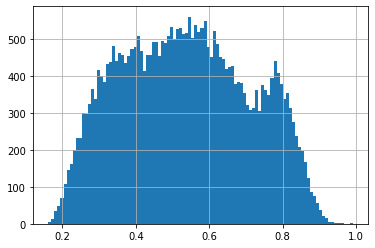

In [110]:
hist = cmudict_7b_english_simplified['combined_likelihood_normalized_by_frequency'].hist(bins=100)

## Write Output to CSV

In [92]:
cmudict_7b_english.to_csv(os.path.join(DATA_DIRECTORY, 'cmu_7b_metrics.csv'), index=False)

In [93]:
cmudict_7b_english_simplified.to_csv(os.path.join(DATA_DIRECTORY, 'cmu_7b_metrics_simplified.csv'), index=False)